## Generate heatmaps for unselected libraries 

Make heatmaps to explore selected aminoacid changes

In [5]:
# import packages, define correlation function for pairplots 
import numpy as np
import itertools
import math
import pandas as pd
import time
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
import csv
import venn
from numpy import cov
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from numpy import cov
import seaborn as sns
from itertools import islice

pd.set_option('display.max_columns', None)
sns.set(style="white")

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    

In [6]:
# This information has to be input manually: File names, barcode flank sequences 

datasets = \
    {
    'NP_11_25'    : 'NP_11_25_BCCounts.csv', # PacBio of glycerol stock
    'NP_11_24_01' : 'NP_11_24_01_BCCounts.csv', # illumina of glycerol stock
    'NP_11_24_10' : 'NP_11_24_10_BCCounts.csv', # Glycerol1 full aliquot outgrowth
    'NP_11_24_11' : 'NP_11_24_11_BCCounts.csv', # Glycerol2 full aliquot outgrowth
    'NP_11_24_18' : 'NP_11_24_18_BCCounts.csv', # Glycerol1 outgrowth fewer PCR steps
    'NP_11_24_19' : 'NP_11_24_19_BCCounts.csv', # Glycerol2 outgrowth fewer PCR steps
    'NP_11_27_21' : 'NP_11_27_21_BCCounts.csv', # Glycerol stock pick
    'NP_11_27_22' : 'NP_11_27_22_BCCounts.csv', # Preselection outgrowth (no aTc)
    'NP_11_27_23' : 'NP_11_27_23_BCCounts.csv', # Preselection outgrowth (with aTc)
    'NP_11_27_24' : 'NP_11_27_24_BCCounts.csv', # Selection replicate 1
    'NP_11_27_25' : 'NP_11_27_25_BCCounts.csv' # Selection replicate 2
    }

PBlookupTable = 'NP_11_21_1_BB_AB_lookupTable.csv'
PBallBCs = datasets['NP_11_25']
illuminaGlycerol = 'NP_11_24_01'
outgrowths = list(islice(datasets,2,9))
selections = list(islice(datasets,9,11))

# Make a dataframe with all of the data (each barcode and its frequency in each dataset)
# Switch to outer merges so that all data is retained at each step

BCDF = pd.read_csv(PBlookupTable, index_col = 0).reset_index().rename(columns = {'Barcode_sequence':'Barcode'})

for experiment in datasets:
    dataDF = pd.read_csv(datasets[experiment])
    BCDF = BCDF.merge(dataDF, how = 'outer', on = 'Barcode')


In [7]:
# Get the mutations into 3 columns

# Retrieve original AA, mutant AA and the position (corrected)
def parseMut(row):
    mut = row['correctedAAmut']
    if pd.isnull(mut):
        return np.nan, np.nan, np.nan
    if mut == 'WT':
        return 'WT', 'WT', 'WT'
    else:
        originalAA = mut[:1]
        mutAA = str(mut[-1:])
        mutPos = int(mut[1:-1])
        return originalAA, mutAA, mutPos

BCDF['MutParsed'] = BCDF.apply(lambda row: parseMut(row), axis=1)
BCDF[['OriginalAA','MutAA', 'AAPosition']] = pd.DataFrame(BCDF.MutParsed.tolist(), index= BCDF.index)
BCDF.drop(columns = 'MutParsed', inplace = True)


In [10]:
# Get normalized enrichment values on a log scale and perform averages
    
# # # Add 0.01 to each value so that there are no errors
# # naValues = {i : 0.01 for i in listOfFileNames}
# # filledInBCDF = BCDF#.fillna(value=naValues)

# Get enrichment value
# Normalize to total reads
for experiment in datasets:
    if experiment != 'NP_11_25':
        reads = BCDF[experiment]
        totalReads = reads.sum()
        pacbioTotalReads = BCDF['NP_11_25'].sum()
        BCDF[experiment + '_norm_enrich'] = np.log((reads/totalReads)/(BCDF['NP_11_25']/pacbioTotalReads))

# Get enrichment value
# Normalize to total reads
for experiment in selections:
    BCDF[experiment + '_selection_enrich'] = BCDF[experiment + '_norm_enrich'] - BCDF['NP_11_27_23_norm_enrich']


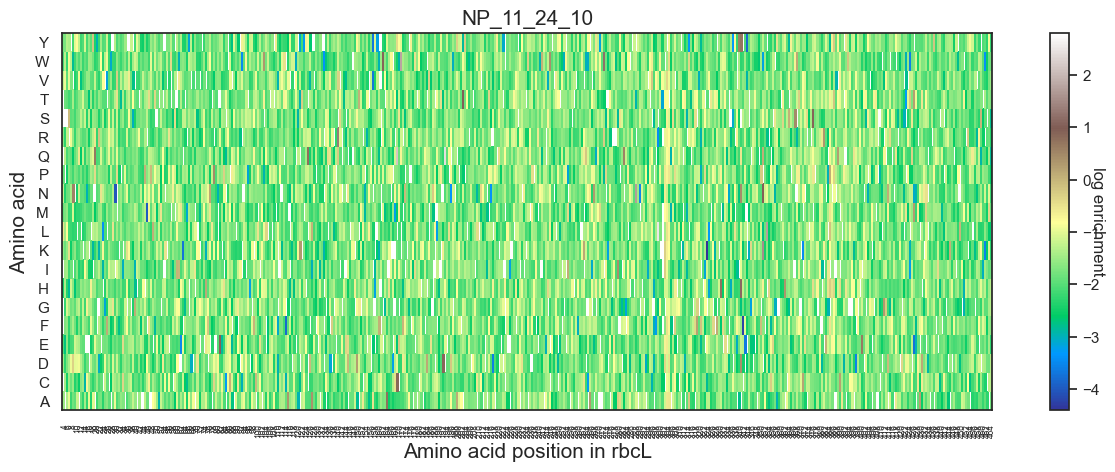

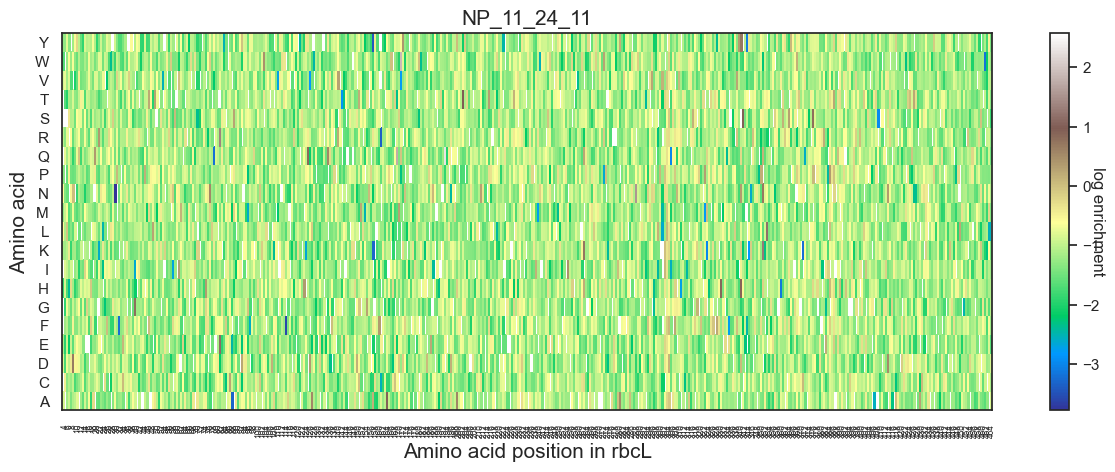

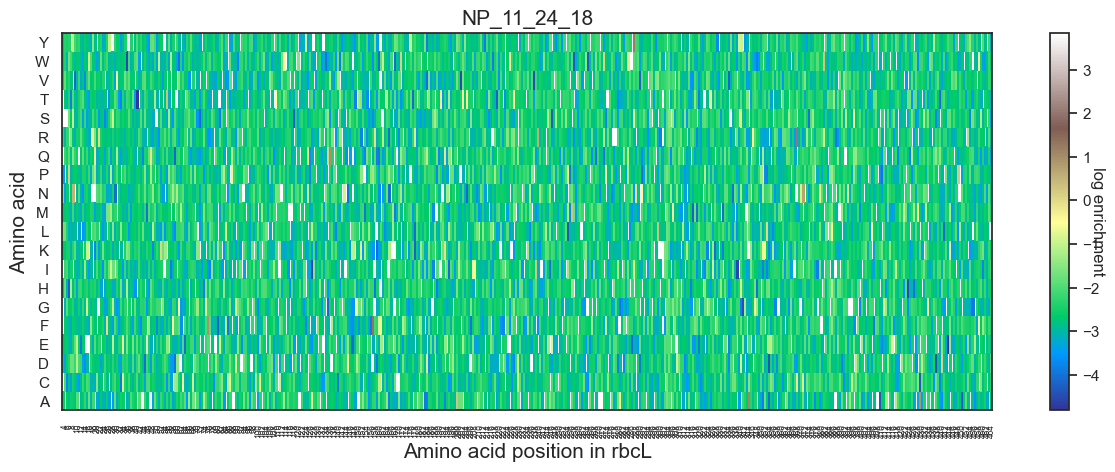

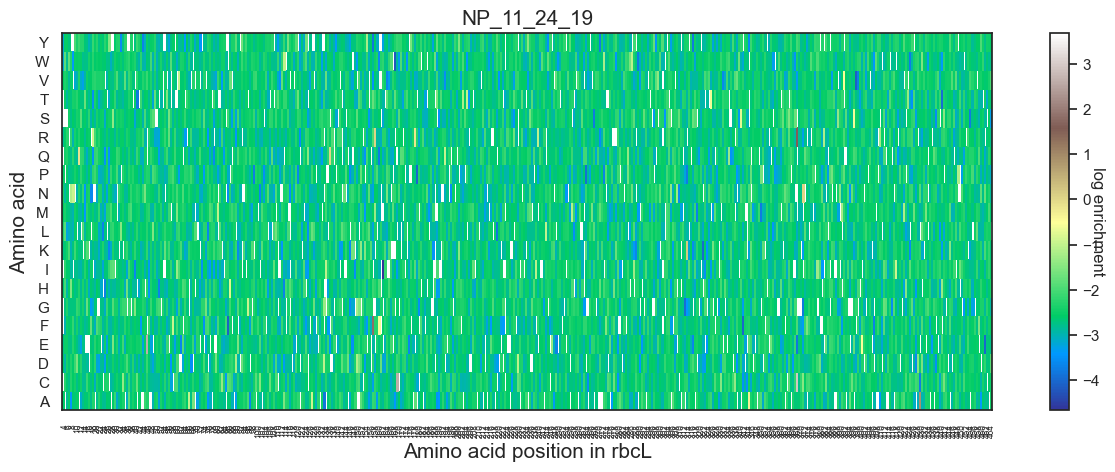

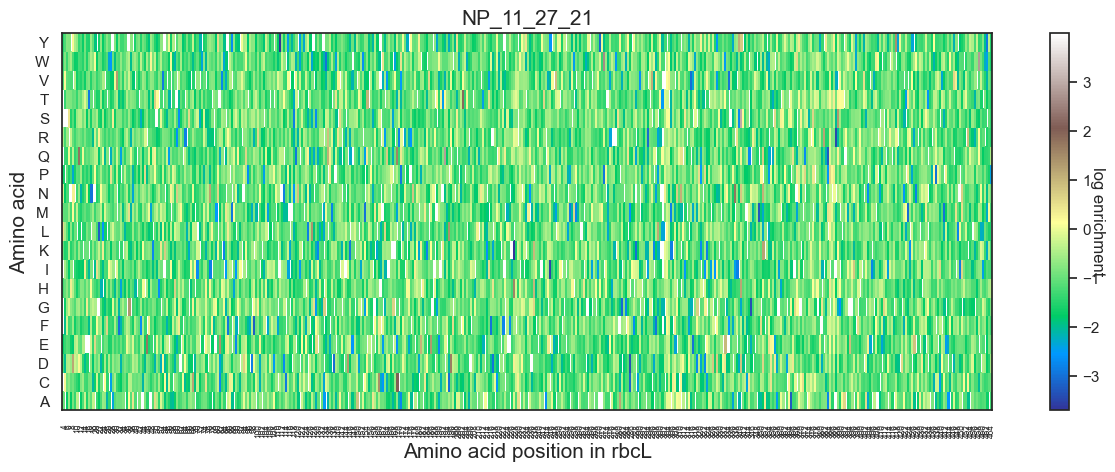

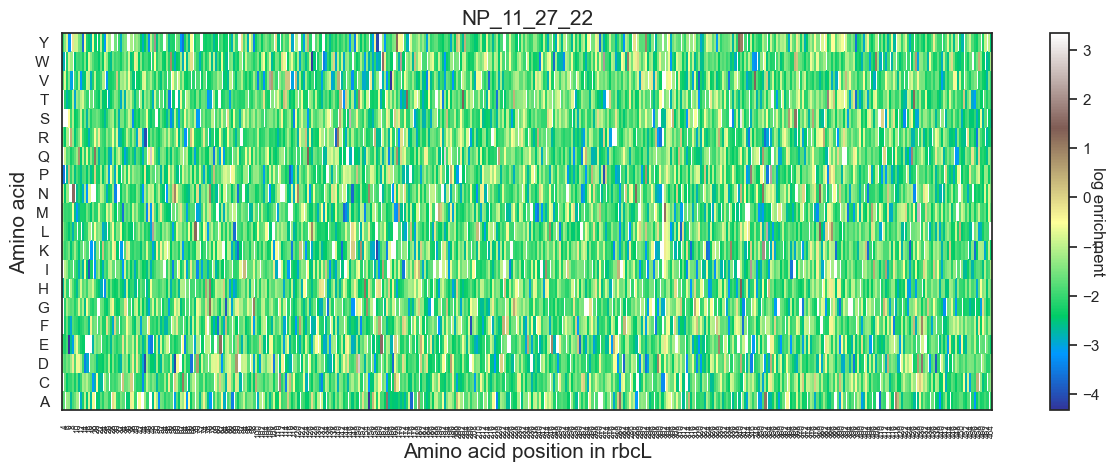

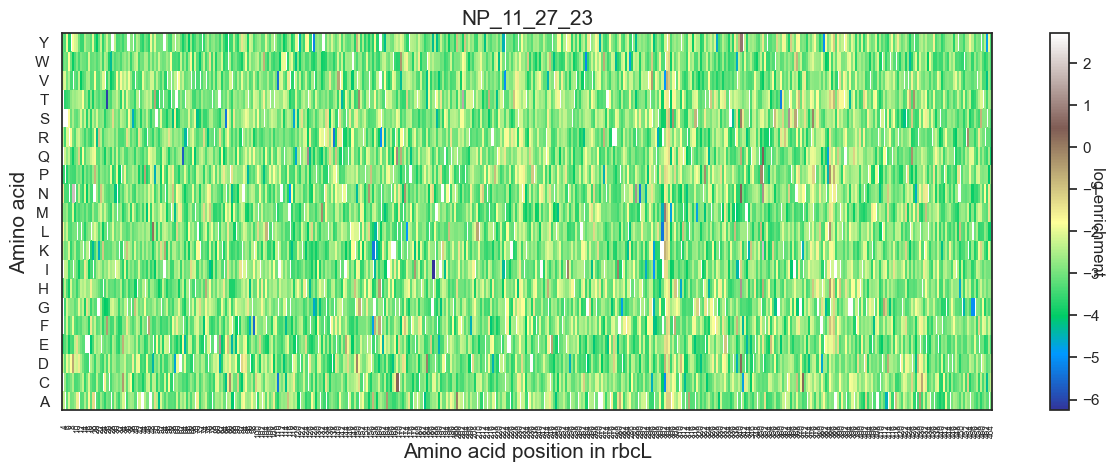

In [14]:
# Heatmap showing each individual mutation read frequency

for experiment in outgrowths:
    enrichment = experiment + '_norm_enrich'

    positionAAFreq = BCDF.groupby(['AAPosition', 'MutAA'])[enrichment].mean()
    dfPositionAAFreq = positionAAFreq.to_frame(name = enrichment)
    pivotBCs = dfPositionAAFreq.pivot_table(index = 'MutAA', columns = 'AAPosition', values = enrichment)

    # Convert pivot table to regular dataframe
    pivotBCsReg = pd.DataFrame(pivotBCs.to_records()).set_index('MutAA')

    fig, (ax1) = plt.subplots(1, tight_layout=False, figsize=(15,5), dpi = 100)
    pcmBCs = ax1.pcolor(pivotBCsReg, cmap = 'terrain')

    ax1.set_title(experiment, size = 15)
    ax1.set_xlabel('Amino acid position in rbcL', size = 15)
    ax1.set_ylabel('Amino acid', size = 15)
    # This sets the ticks in the middle
    ax1.set_yticks(np.arange(0.5, 20.5))
    ax1.set_yticklabels(pivotBCs.index)
    cbar = plt.colorbar(pcmBCs, ax = ax1)
    cbar.set_label('log enrichment', rotation = 270)

    # Convert xticks to integers, rotate them, place ticks in middle of heatmap squares
    plt.xticks(np.arange(0.5, len(pivotBCsReg.columns), 1), 
               np.float_(pivotBCsReg.columns).astype(int), 
               rotation = 90, size = 6)
#     plt.xlim(330,350)


    # Display only every other position
    plt.setp(ax1.get_xticklabels()[::2], visible=False)


#     plt.savefig(experiment + '_heatmap.pdf')

    plt.show()

In [15]:
filledInBCDF[filledInBCDF['AAPosition'] == 303]

NameError: name 'filledInBCDF' is not defined

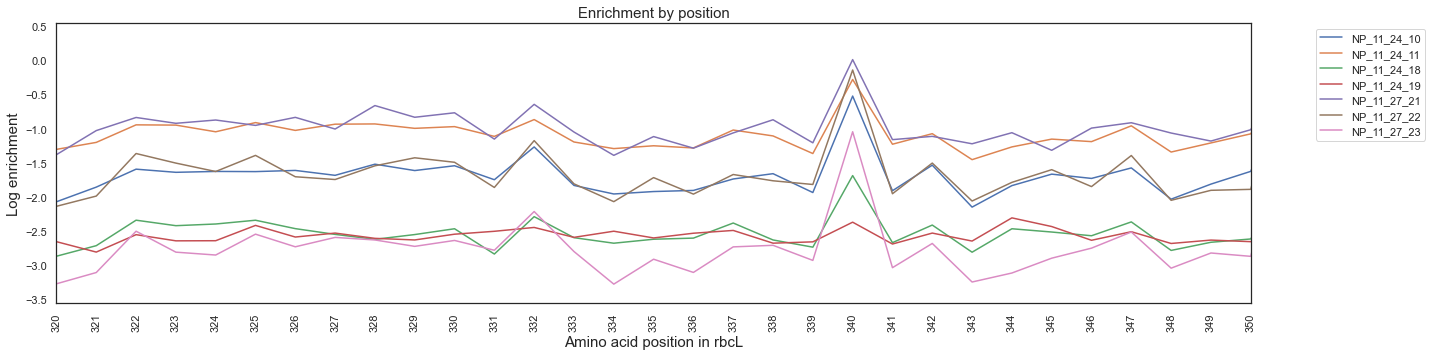

<Figure size 1440x360 with 0 Axes>

In [30]:
# Scatterplot by position
plt.figure(figsize=(20, 5))

for experiment in outgrowths:
    enrichment = experiment + '_norm_enrich'

    positionFreq = BCDF.groupby(['AAPosition'])[enrichment].mean()
    dfPositionFreq = positionFreq.to_frame(name = enrichment)
    plt.plot(dfPositionFreq.index, dfPositionFreq[enrichment], label = experiment)

plt.xlabel('Amino acid position in rbcL', size = 15)
plt.ylabel('Log enrichment', size = 15)
plt.title('Enrichment by position', size = 15)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xticks(np.arange(0, 500, 1), rotation = 90)

plt.xlim(320,350)
plt.figure(figsize=(20, 5))
plt.savefig('positionEffects.pdf')





<function matplotlib.pyplot.show(close=None, block=None)>

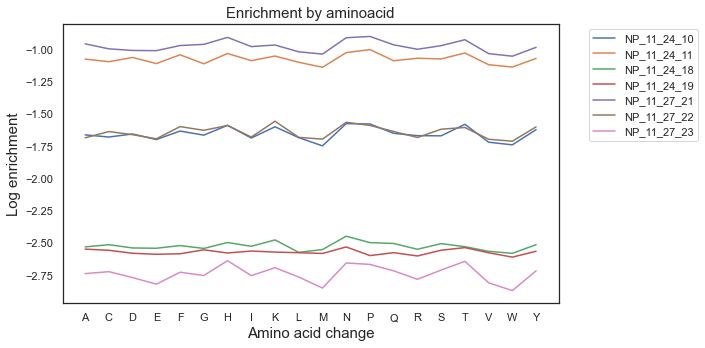

In [29]:
# Scatterplot by AA
plt.figure(figsize = (10,5))

for experiment in outgrowths:
    enrichment = experiment + '_norm_enrich'
    AAFreq = BCDF.groupby(['MutAA'])[enrichment].mean()
    dfAAFreq = AAFreq.to_frame(name = enrichment)
    plt.plot(dfAAFreq.index, dfAAFreq[enrichment], label = experiment)

plt.xlabel('Amino acid change', size = 15)
plt.ylabel('Log enrichment', size = 15)
plt.title('Enrichment by aminoacid', size = 15)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('AAeffects.pdf')
plt.show
